# GNN Model Architecture

In this notebook, we'll implement the core architecture of the Graph Neural Network model as described in Scarselli et al.'s paper. We'll focus on implementing the two key functions: the local transition function (f_w) and the local output function (g_w).

## 1. Review of GNN Model Structure

Before diving into implementation, let's review the overall structure of the GNN model:

1. **Input**: A graph with node features and optionally edge features
2. **Processing**:
   - Each node has a state vector that captures contextual information
   - Node states are updated iteratively until convergence
   - The update happens through a local transition function
3. **Output**:
   - Node-level outputs are generated using a local output function
   - Graph-level outputs can be obtained by aggregating node outputs

The key components we need to implement are:

- **Local Transition Function (f_w)**: Updates node states based on neighborhood information
- **Local Output Function (g_w)**: Generates outputs from node states
- **Global Readout Function**: Aggregates node-level information to produce graph-level outputs

## 2. Implementation of Transition Functions

The local transition function is the heart of the GNN model. According to Scarselli's paper, there are several ways to implement this function.

### 2.1 Linear Transition Function

Let's first implement a linear version of the transition function:

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class LinearTransitionFunction(nn.Module):
    """
    Linear implementation of the GNN local transition function.
    
    The function updates a node's state based on its features, neighbors' states,
    and edge features using linear transformations.
    """
    def __init__(self, node_feature_dim, state_dim, edge_feature_dim=0):
        """
        Initialize the linear transition function.
        
        Args:
            node_feature_dim: Dimension of node features
            state_dim: Dimension of node state vectors
            edge_feature_dim: Dimension of edge features (0 if not used)
        """
        super(LinearTransitionFunction, self).__init__()
        
        self.node_feature_dim = node_feature_dim
        self.state_dim = state_dim
        self.edge_feature_dim = edge_feature_dim
        
        # Linear transformation for node features
        self.W_node = nn.Linear(node_feature_dim, state_dim, bias=False)
        
        # Linear transformation for neighbor states
        self.W_neighbor = nn.Linear(state_dim, state_dim, bias=False)
        
        # Linear transformation for edge features (if used)
        if edge_feature_dim > 0:
            self.W_edge = nn.Linear(edge_feature_dim, state_dim, bias=False)
        
        # Bias term
        self.bias = nn.Parameter(torch.Tensor(state_dim))
        nn.init.zeros_(self.bias)
    
    def forward(self, node_features, neighbor_states, edge_features=None):
        """
        Forward pass of the transition function.
        
        Args:
            node_features: Node's own features [node_feature_dim]
            neighbor_states: List of neighbor state vectors [num_neighbors, state_dim]
            edge_features: List of edge features [num_neighbors, edge_feature_dim] (optional)
        
        Returns:
            Updated state vector [state_dim]
        """
        # Transform node features
        node_term = self.W_node(node_features)
        
        # Aggregate and transform neighbor states
        if len(neighbor_states) > 0:
            # Stack neighbor states and process
            stacked_neighbors = torch.stack(neighbor_states)
            neighbor_term = self.W_neighbor(stacked_neighbors).sum(dim=0)
        else:
            # No neighbors
            neighbor_term = torch.zeros_like(node_term)
        
        # Process edge features if provided
        edge_term = torch.zeros_like(node_term)
        if edge_features is not None and self.edge_feature_dim > 0 and len(edge_features) > 0:
            stacked_edges = torch.stack(edge_features)
            edge_term = self.W_edge(stacked_edges).sum(dim=0)
        
        # Combine terms and apply activation
        combined = node_term + neighbor_term + edge_term + self.bias
        
        # Apply tanh to ensure contraction property
        new_state = torch.tanh(combined)
        
        return new_state
    
    def init_as_contraction(self):
        """
        Initialize weights to ensure the transition function is a contraction mapping.
        This is done by scaling the neighbor weight matrix to have spectral radius < 1.
        """
        with torch.no_grad():
            # Calculate the spectral radius (maximum absolute eigenvalue)
            weight = self.W_neighbor.weight.data
            eigenvalues = torch.linalg.eigvals(weight)
            spectral_radius = torch.max(torch.abs(eigenvalues))
            
            # Scale weight matrix if spectral radius >= 1
            if spectral_radius >= 1:
                scaling_factor = 0.9 / spectral_radius  # Ensure spectral radius of 0.9
                self.W_neighbor.weight.data *= scaling_factor
                print(f"Scaled neighbor weights by {scaling_factor:.4f} to ensure contraction property")

The linear transition function implements the formula:

$$h_v^{(t+1)} = \tanh(W_{node} \cdot x_v + \sum_{u \in N(v)} W_{neighbor} \cdot h_u^{(t)} + \sum_{e_{vu}} W_{edge} \cdot x_{e_{vu}} + b)$$

Where:
- $h_v^{(t+1)}$ is the updated state of node $v$
- $x_v$ is the feature vector of node $v$
- $N(v)$ is the set of neighbors of node $v$
- $h_u^{(t)}$ is the current state of neighbor $u$
- $x_{e_{vu}}$ is the feature vector of edge from $v$ to $u$
- $W_{node}$, $W_{neighbor}$, $W_{edge}$ are weight matrices
- $b$ is a bias vector

The `tanh` activation ensures that the function is a contraction mapping, which is necessary for convergence.

### 2.2 Neural Network Transition Function

Scarselli et al. also proposed using a neural network as the transition function. Let's implement this:

In [2]:
class MLPTransitionFunction(nn.Module):
    """
    Neural network implementation of the GNN local transition function.
    
    Uses a multi-layer perceptron to update a node's state based on its features,
    neighbors' states, and edge features.
    """
    def __init__(self, node_feature_dim, state_dim, edge_feature_dim=0, hidden_dim=32):
        """
        Initialize the MLP transition function.
        
        Args:
            node_feature_dim: Dimension of node features
            state_dim: Dimension of node state vectors
            edge_feature_dim: Dimension of edge features (0 if not used)
            hidden_dim: Dimension of hidden layers in the MLP
        """
        super(MLPTransitionFunction, self).__init__()
        
        self.node_feature_dim = node_feature_dim
        self.state_dim = state_dim
        self.edge_feature_dim = edge_feature_dim
        
        # Determine input dimension based on whether edge features are used
        input_dim = node_feature_dim + state_dim
        if edge_feature_dim > 0:
            input_dim += edge_feature_dim
        
        # MLP for processing combined inputs
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, state_dim),
            nn.Tanh()  # Final tanh to ensure contraction
        )
        
        # Initialize weights properly
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights to help ensure the contraction property."""
        for layer in self.mlp:
            if isinstance(layer, nn.Linear):
                # Initialize with small weights to help ensure contraction
                nn.init.xavier_uniform_(layer.weight, gain=0.5)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
    
    def forward(self, node_features, neighbor_states, edge_features=None):
        """
        Forward pass of the transition function.
        
        Args:
            node_features: Node's own features [node_feature_dim]
            neighbor_states: List of neighbor state vectors [num_neighbors, state_dim]
            edge_features: List of edge features [num_neighbors, edge_feature_dim] (optional)
        
        Returns:
            Updated state vector [state_dim]
        """
        # Aggregate neighbor states (mean pooling)
        if len(neighbor_states) > 0:
            neighbor_aggr = torch.stack(neighbor_states).mean(dim=0)
        else:
            neighbor_aggr = torch.zeros(self.state_dim, device=node_features.device)
        
        # Combine node features and aggregated neighbor states
        combined = torch.cat([node_features, neighbor_aggr], dim=0)
        
        # Add edge features if provided
        if edge_features is not None and self.edge_feature_dim > 0 and len(edge_features) > 0:
            edge_aggr = torch.stack(edge_features).mean(dim=0)
            combined = torch.cat([combined, edge_aggr], dim=0)
        
        # Process through MLP
        new_state = self.mlp(combined)
        
        return new_state

The MLP transition function provides more expressiveness than the linear version, as it can capture non-linear relationships between a node's features, its neighbor states, and edge features.

## 3. Implementation of Output Functions

The local output function generates outputs for each node based on its state and features. According to Scarselli's paper, this function can also be implemented in different ways.

### 3.1 Linear Output Function

Let's implement a simple linear output function:

In [3]:
class LinearOutputFunction(nn.Module):
    """
    Linear implementation of the GNN local output function.
    
    Generates outputs for nodes based on their states and features.
    """
    def __init__(self, node_feature_dim, state_dim, output_dim):
        """
        Initialize the linear output function.
        
        Args:
            node_feature_dim: Dimension of node features
            state_dim: Dimension of node state vectors
            output_dim: Dimension of output vectors
        """
        super(LinearOutputFunction, self).__init__()
        
        # Linear transformation for node states
        self.W_state = nn.Linear(state_dim, output_dim)
        
        # Linear transformation for node features (optional)
        self.W_node = nn.Linear(node_feature_dim, output_dim)
        
        # Initialize with small weights
        nn.init.xavier_uniform_(self.W_state.weight, gain=0.1)
        nn.init.xavier_uniform_(self.W_node.weight, gain=0.1)
        nn.init.zeros_(self.W_state.bias)
    
    def forward(self, node_features, node_state):
        """
        Forward pass of the output function.
        
        Args:
            node_features: Node's features [node_feature_dim]
            node_state: Node's state vector [state_dim]
        
        Returns:
            Output vector [output_dim]
        """
        # Transform node state
        state_term = self.W_state(node_state)
        
        # Transform node features
        node_term = self.W_node(node_features)
        
        # Combine terms
        output = state_term + node_term
        
        return output

### 3.2 Neural Network Output Function

For more expressive power, we can also implement the output function as a neural network:

In [4]:
class MLPOutputFunction(nn.Module):
    """
    Neural network implementation of the GNN local output function.
    
    Uses a multi-layer perceptron to generate outputs for nodes based on 
    their states and features.
    """
    def __init__(self, node_feature_dim, state_dim, output_dim, hidden_dim=32):
        """
        Initialize the MLP output function.
        
        Args:
            node_feature_dim: Dimension of node features
            state_dim: Dimension of node state vectors
            output_dim: Dimension of output vectors
            hidden_dim: Dimension of hidden layers in the MLP
        """
        super(MLPOutputFunction, self).__init__()
        
        # MLP for processing combined inputs
        self.mlp = nn.Sequential(
            nn.Linear(node_feature_dim + state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
            # No activation on the output layer for regression tasks
            # For classification tasks, softmax would be applied externally
        )
        
        # Initialize weights properly
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights with Xavier initialization."""
        for layer in self.mlp:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
    
    def forward(self, node_features, node_state):
        """
        Forward pass of the output function.
        
        Args:
            node_features: Node's features [node_feature_dim]
            node_state: Node's state vector [state_dim]
        
        Returns:
            Output vector [output_dim]
        """
        # Combine node features and state
        combined = torch.cat([node_features, node_state], dim=0)
        
        # Process through MLP
        output = self.mlp(combined)
        
        return output

## 4. Implementing the Global Readout Function

For graph-level tasks, we need a global readout function that aggregates node-level information. This was not explicitly defined in Scarselli's paper but is a common component in modern GNNs:

In [6]:
class GlobalReadout(nn.Module):
    """
    Global readout function that aggregates node states and outputs
    to produce graph-level outputs.
    """
    def __init__(self, state_dim, output_dim, hidden_dim=32):
        """
        Initialize the global readout function.
        
        Args:
            state_dim: Dimension of node state vectors
            output_dim: Dimension of graph-level output
            hidden_dim: Dimension of hidden layers
        """
        super(GlobalReadout, self).__init__()
        
        # MLP for processing aggregated states
        self.mlp = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, node_states, node_outputs=None):
        """
        Forward pass of the global readout function.
        
        Args:
            node_states: List of node state vectors
            node_outputs: List of node output vectors (optional)
        
        Returns:
            Graph-level output vector
        """
        # Aggregate node states (mean pooling)
        if len(node_states) > 0:
            aggregated = torch.stack(node_states).mean(dim=0)
        else:
            return None  # Empty graph
        
        # Process through MLP
        graph_output = self.mlp(aggregated)
        
        return graph_output

In the next part, we'll integrate these components into a complete GNN model and implement the iterative state update mechanism.

## 5. Integrating Components into a Complete GNN Model

Now that we've implemented the individual components, let's integrate them into a complete GNN model that follows Scarselli et al.'s framework.

### 5.1 Basic GNN Model

In [7]:
class BasicGNN(nn.Module):
    """
    Basic implementation of the Graph Neural Network model.
    
    This model follows the approach described in "The Graph Neural Network Model"
    by Scarselli et al., using iterative state updates until convergence.
    """
    def __init__(
        self,
        node_feature_dim,
        state_dim,
        output_dim,
        edge_feature_dim=0,
        hidden_dim=32,
        use_mlp=False
    ):
        """
        Initialize the GNN model.
        
        Args:
            node_feature_dim: Dimension of node features
            state_dim: Dimension of node state vectors
            output_dim: Dimension of node/graph outputs
            edge_feature_dim: Dimension of edge features (0 if not used)
            hidden_dim: Dimension of hidden layers (for MLP variants)
            use_mlp: Whether to use MLP or linear implementations
        """
        super(BasicGNN, self).__init__()
        
        self.node_feature_dim = node_feature_dim
        self.state_dim = state_dim
        self.output_dim = output_dim
        self.edge_feature_dim = edge_feature_dim
        
        # Select transition function implementation
        if use_mlp:
            self.transition_function = MLPTransitionFunction(
                node_feature_dim, state_dim, edge_feature_dim, hidden_dim
            )
        else:
            self.transition_function = LinearTransitionFunction(
                node_feature_dim, state_dim, edge_feature_dim
            )
            # Initialize as contraction map
            self.transition_function.init_as_contraction()
        
        # Select output function implementation
        if use_mlp:
            self.output_function = MLPOutputFunction(
                node_feature_dim, state_dim, output_dim, hidden_dim
            )
        else:
            self.output_function = LinearOutputFunction(
                node_feature_dim, state_dim, output_dim
            )
        
        # Global readout for graph-level tasks
        self.global_readout = GlobalReadout(state_dim, output_dim, hidden_dim)
    
    def initialize_states(self, graph_data):
        """
        Initialize state vectors for all nodes in the graph.
        
        Args:
            graph_data: Dictionary containing graph information
        
        Returns:
            Dictionary mapping node IDs to initial state vectors
        """
        node_states = {}
        for node_id in graph_data['nodes']:
            # Initialize with zeros
            node_states[node_id] = torch.zeros(self.state_dim)
        return node_states
    
    def forward(
        self,
        graph_data,
        max_iterations=30,
        convergence_threshold=1e-4,
        return_states_history=False
    ):
        """
        Forward pass of the GNN model.
        
        Args:
            graph_data: Dictionary containing:
                - 'nodes': Dict mapping node IDs to feature tensors
                - 'edges': Dict mapping (source, target) to feature tensors
                - 'adjacency': Dict mapping node IDs to lists of neighbor IDs
            max_iterations: Maximum number of state update iterations
            convergence_threshold: Threshold for convergence check
            return_states_history: Whether to return the history of states
            
        Returns:
            Dictionary containing:
                - 'node_outputs': Dict mapping node IDs to output tensors
                - 'graph_output': Graph-level output tensor
                - 'states_history': List of state dictionaries (if requested)
        """
        # Extract graph components
        nodes = graph_data['nodes']
        edges = graph_data.get('edges', {})
        adjacency = graph_data['adjacency']
        
        # Initialize node states
        node_states = self.initialize_states(graph_data)
        
        # Store state history for visualization
        states_history = [node_states.copy()]
        
        # Iterative state updates
        for t in range(max_iterations):
            # Store old states for convergence check
            old_states = {node_id: state.clone() for node_id, state in node_states.items()}
            
            # Update each node's state
            new_states = {}
            for node_id, node_features in nodes.items():
                # Get neighbor states
                neighbor_ids = adjacency.get(node_id, [])
                neighbor_states = [node_states[n_id] for n_id in neighbor_ids if n_id in node_states]
                
                # Get edge features if available
                edge_features = []
                if edges and self.edge_feature_dim > 0:
                    for n_id in neighbor_ids:
                        if (node_id, n_id) in edges:
                            edge_features.append(edges[(node_id, n_id)])
                
                # Update state using transition function
                new_state = self.transition_function(
                    node_features, neighbor_states, edge_features if edge_features else None
                )
                
                # Store new state
                new_states[node_id] = new_state
            
            # Update states
            node_states = new_states
            
            # Add to history
            states_history.append(node_states.copy())
            
            # Check for convergence
            max_diff = 0.0
            for node_id in nodes:
                if node_id in old_states:
                    diff = torch.norm(node_states[node_id] - old_states[node_id])
                    max_diff = max(max_diff, diff.item())
            
            if max_diff < convergence_threshold:
                print(f"Converged after {t+1} iterations")
                break
        
        # Compute node outputs
        node_outputs = {}
        for node_id, node_features in nodes.items():
            node_outputs[node_id] = self.output_function(node_features, node_states[node_id])
        
        # Compute graph-level output
        graph_output = self.global_readout(list(node_states.values()))
        
        # Prepare return dictionary
        result = {
            'node_outputs': node_outputs,
            'graph_output': graph_output
        }
        
        if return_states_history:
            result['states_history'] = states_history
        
        return result

The `BasicGNN` model incorporates all the components we've implemented:
1. It initializes node states
2. It updates these states iteratively using the transition function
3. It checks for convergence based on the maximum change in states
4. It computes node-level outputs using the output function
5. It computes a graph-level output using the global readout
6. 
### 5.2 Helper Functions for Graph Data Preparation

Before we can use our GNN model, we need some helper functions to prepare graph data in the right format:

In [8]:
def prepare_graph_data(networkx_graph, node_feature_dim=None, edge_feature_dim=None):
    """
    Convert a NetworkX graph to the dictionary format expected by our GNN model.
    
    Args:
        networkx_graph: NetworkX graph object
        node_feature_dim: If provided, initialize random node features of this dimension
        edge_feature_dim: If provided, initialize random edge features of this dimension
        
    Returns:
        Dictionary containing graph data in the format expected by the GNN model
    """
    graph_data = {
        'nodes': {},
        'edges': {},
        'adjacency': {}
    }
    
    # Add nodes with features
    for node in networkx_graph.nodes():
        if 'feature' in networkx_graph.nodes[node]:
            # Use existing features
            feature = torch.tensor(networkx_graph.nodes[node]['feature'], dtype=torch.float32)
        elif node_feature_dim is not None:
            # Create random features
            feature = torch.randn(node_feature_dim)
        else:
            # Default to 1D feature
            feature = torch.tensor([1.0], dtype=torch.float32)
        
        graph_data['nodes'][node] = feature
    
    # Add edges with features
    for source, target in networkx_graph.edges():
        if 'feature' in networkx_graph.edges[(source, target)]:
            # Use existing features
            feature = torch.tensor(networkx_graph.edges[(source, target)]['feature'], dtype=torch.float32)
        elif edge_feature_dim is not None:
            # Create random features
            feature = torch.randn(edge_feature_dim)
        else:
            # Default to 1D feature
            feature = torch.tensor([1.0], dtype=torch.float32)
        
        graph_data['edges'][(source, target)] = feature
        
        # For undirected graphs, add the reverse edge too
        if not networkx_graph.is_directed():
            graph_data['edges'][(target, source)] = feature
    
    # Create adjacency lists
    for node in networkx_graph.nodes():
        graph_data['adjacency'][node] = list(networkx_graph.neighbors(node))
    
    return graph_data

def visualize_gnn_states(graph, states_history, max_iterations=3):
    """
    Visualize how GNN states evolve over iterations.
    
    Args:
        graph: NetworkX graph
        states_history: List of dictionaries mapping node IDs to state tensors
        max_iterations: Maximum number of iterations to visualize
    """
    # Limit iterations to display
    iterations = min(len(states_history), max_iterations)
    
    # Create a spring layout (consistent across iterations)
    pos = nx.spring_layout(graph, seed=42)
    
    # Create subplots
    fig, axes = plt.subplots(1, iterations, figsize=(5*iterations, 6))
    if iterations == 1:
        axes = [axes]  # Make sure axes is a list
    
    # For each iteration
    for t in range(iterations):
        ax = axes[t]
        states = states_history[t]
        
        # Convert states to numpy arrays and compute norms
        state_norms = {}
        for node, state in states.items():
            if isinstance(state, torch.Tensor):
                state_norms[node] = torch.norm(state).item()
            else:
                state_norms[node] = np.linalg.norm(state)
        
        # Find min and max norms for color scaling
        min_norm = min(state_norms.values()) if state_norms else 0
        max_norm = max(state_norms.values()) if state_norms else 1
        
        # Normalize norms to [0,1] for colormap
        normalized_norms = {
            node: (norm - min_norm) / (max_norm - min_norm) if max_norm > min_norm else 0.5
            for node, norm in state_norms.items()
        }
        
        # Node colors based on state norms
        node_colors = [plt.cm.viridis(normalized_norms.get(node, 0.5)) for node in graph.nodes()]
        
        # Draw the graph
        nx.draw_networkx(graph, pos=pos, ax=ax, node_color=node_colors, 
                        node_size=500, with_labels=True)
        
        ax.set_title(f"Iteration {t+1}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

### 5.3 Example: Running the GNN on a Simple Graph

Now, let's demonstrate how to use our GNN model on a simple graph:

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

Converged after 8 iterations
Converged after 4 iterations
Linear GNN Node Outputs:
Node 0: -0.3538
Node 1: -0.3674
Node 2: -0.3872
Node 3: -0.3874
Node 4: -0.3774

MLP GNN Node Outputs:
Node 0: 0.0576
Node 1: 0.0244
Node 2: 0.0200
Node 3: -0.0248
Node 4: -0.0703

Linear GNN Graph Output: 0.1376
MLP GNN Graph Output: 0.2574

Linear GNN State Evolution:


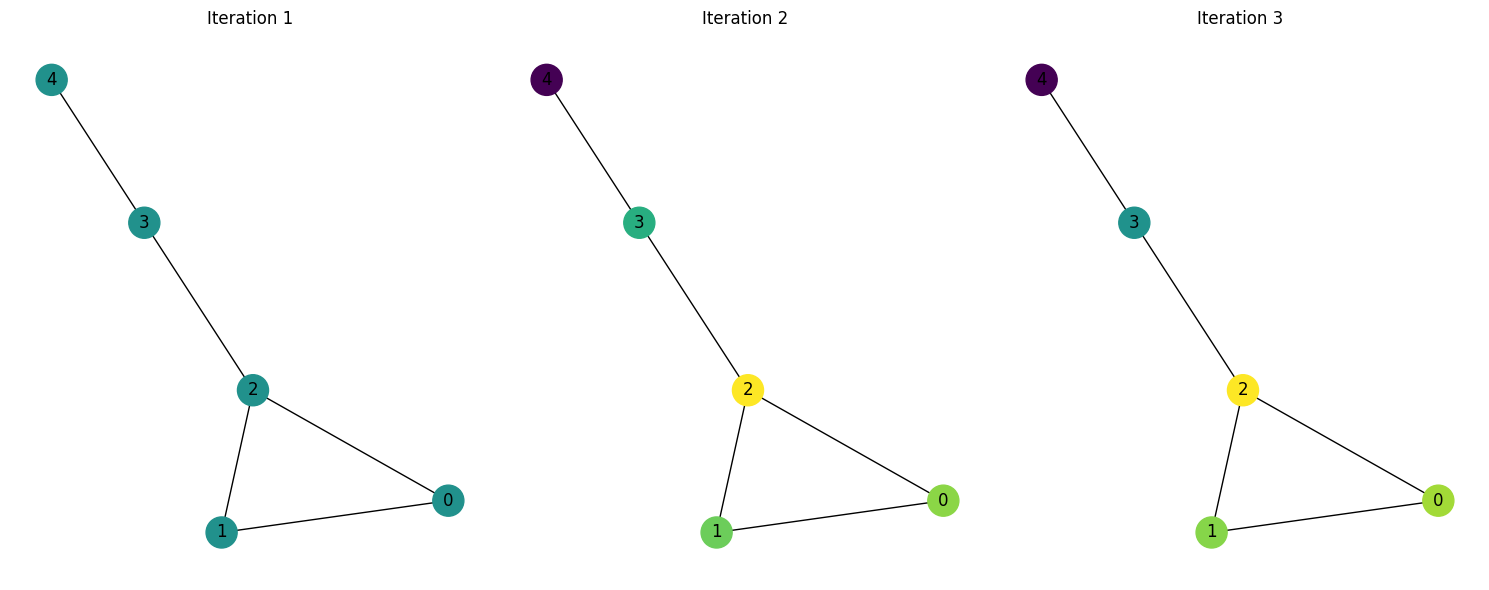


MLP GNN State Evolution:


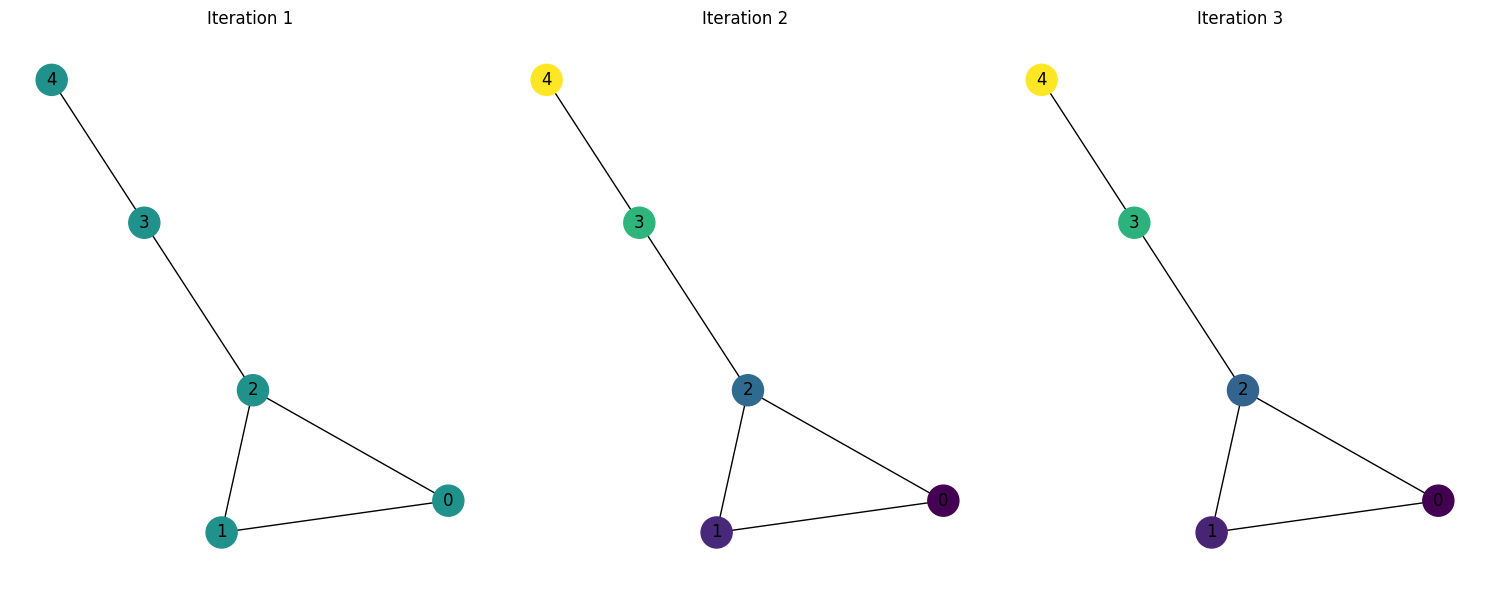

In [13]:
def gnn_example():
    """Run an example of the complete GNN model."""
    # Create a simple graph
    G = nx.Graph()
    G.add_nodes_from(range(5))
    G.add_edges_from([(0, 1), (0, 2), (1, 2), (2, 3), (3, 4)])
    
    # Set node features (2D)
    for i in range(5):
        G.nodes[i]['feature'] = np.array([i/4, 1-i/4])
    
    # Set edge features (1D)
    for i, j in G.edges():
        G.edges[(i, j)]['feature'] = np.array([1.0])
    
    # Prepare data
    graph_data = prepare_graph_data(G)
    
    # Create and initialize GNN model
    node_feature_dim = 2  # 2D node features
    state_dim = 4         # 4D state vectors
    output_dim = 1        # 1D output
    edge_feature_dim = 1  # 1D edge features
    
    # Create both linear and MLP models for comparison
    linear_gnn = BasicGNN(
        node_feature_dim=node_feature_dim,
        state_dim=state_dim,
        output_dim=output_dim,
        edge_feature_dim=edge_feature_dim,
        use_mlp=False
    )
    
    mlp_gnn = BasicGNN(
        node_feature_dim=node_feature_dim,
        state_dim=state_dim,
        output_dim=output_dim,
        edge_feature_dim=edge_feature_dim,
        use_mlp=True
    )
    
    # Process with linear GNN
    linear_result = linear_gnn(graph_data, max_iterations=20, return_states_history=True)
    
    # Process with MLP GNN
    mlp_result = mlp_gnn(graph_data, max_iterations=20, return_states_history=True)
    
    # Print node outputs
    print("Linear GNN Node Outputs:")
    for node, output in linear_result['node_outputs'].items():
        print(f"Node {node}: {output.item():.4f}")
    
    print("\nMLP GNN Node Outputs:")
    for node, output in mlp_result['node_outputs'].items():
        print(f"Node {node}: {output.item():.4f}")
    
    # Print graph outputs
    print(f"\nLinear GNN Graph Output: {linear_result['graph_output'].item():.4f}")
    print(f"MLP GNN Graph Output: {mlp_result['graph_output'].item():.4f}")
    
    # Visualize state evolution
    print("\nLinear GNN State Evolution:")
    visualize_gnn_states(G, linear_result['states_history'], max_iterations=3)
    
    print("\nMLP GNN State Evolution:")
    visualize_gnn_states(G, mlp_result['states_history'], max_iterations=3)

# Run the example
gnn_example()

## 6. Implementation of GNN Variants

Scarselli et al. discussed several variants of the GNN model. Let's implement some of these variants to show the flexibility of the framework.

### 6.1 Positional GNN

In this variant, we incorporate information about the relative positions or distances between nodes:

In [14]:
class PositionalTransitionFunction(nn.Module):
    """
    Transition function that takes into account relative positions between nodes.
    
    This is useful for spatial graphs where geometric relationships matter.
    """
    def __init__(self, node_feature_dim, state_dim, position_dim=2, hidden_dim=32):
        """
        Initialize the positional transition function.
        
        Args:
            node_feature_dim: Dimension of node features
            state_dim: Dimension of node state vectors
            position_dim: Dimension of position vectors
            hidden_dim: Dimension of hidden layers
        """
        super(PositionalTransitionFunction, self).__init__()
        
        self.node_feature_dim = node_feature_dim
        self.state_dim = state_dim
        self.position_dim = position_dim
        
        # MLP for processing node features
        self.node_mlp = nn.Sequential(
            nn.Linear(node_feature_dim, hidden_dim),
            nn.ReLU()
        )
        
        # MLP for processing neighbor information with positional encoding
        self.neighbor_mlp = nn.Sequential(
            nn.Linear(state_dim + position_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Final MLP to produce the new state
        self.final_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim),
            nn.Tanh()  # Ensure contraction
        )
    
    def forward(self, node_features, neighbor_states, neighbor_positions):
        """
        Forward pass of the positional transition function.
        
        Args:
            node_features: Node's own features [node_feature_dim]
            neighbor_states: List of neighbor state vectors [num_neighbors, state_dim]
            neighbor_positions: List of relative positions to neighbors [num_neighbors, position_dim]
            
        Returns:
            Updated state vector [state_dim]
        """
        # Process node features
        node_embedding = self.node_mlp(node_features)
        
        # Process neighbors with position information
        neighbor_embeddings = []
        for state, position in zip(neighbor_states, neighbor_positions):
            # Combine state and position
            state_pos = torch.cat([state, position], dim=0)
            # Process through MLP
            neighbor_emb = self.neighbor_mlp(state_pos)
            neighbor_embeddings.append(neighbor_emb)
        
        # Aggregate neighbor embeddings (mean pooling)
        if neighbor_embeddings:
            neighbor_aggr = torch.stack(neighbor_embeddings).mean(dim=0)
        else:
            neighbor_aggr = torch.zeros_like(node_embedding)
        
        # Combine node and neighbor information
        combined = torch.cat([node_embedding, neighbor_aggr], dim=0)
        
        # Generate new state
        new_state = self.final_mlp(combined)
        
        return new_state

### 6.2 Time-dependent GNN

For dynamic graphs where time is important, we can implement a time-dependent variant:

In [15]:
class TimeDependentTransitionFunction(nn.Module):
    """
    Transition function that includes a time component.
    
    This is useful for dynamic graphs where the state update may depend on time.
    """
    def __init__(self, node_feature_dim, state_dim, hidden_dim=32):
        """
        Initialize the time-dependent transition function.
        
        Args:
            node_feature_dim: Dimension of node features
            state_dim: Dimension of node state vectors
            hidden_dim: Dimension of hidden layers
        """
        super(TimeDependentTransitionFunction, self).__init__()
        
        # MLP for processing combined inputs with time
        self.mlp = nn.Sequential(
            nn.Linear(node_feature_dim + state_dim + 1, hidden_dim),  # +1 for time
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim),
            nn.Tanh()  # Ensure contraction
        )
    
    def forward(self, node_features, neighbor_states, time_step):
        """
        Forward pass of the time-dependent transition function.
        
        Args:
            node_features: Node's own features [node_feature_dim]
            neighbor_states: List of neighbor state vectors [num_neighbors, state_dim]
            time_step: Current time step (int or float)
            
        Returns:
            Updated state vector [state_dim]
        """
        # Aggregate neighbor states (mean pooling)
        if neighbor_states:
            neighbor_aggr = torch.stack(neighbor_states).mean(dim=0)
        else:
            neighbor_aggr = torch.zeros(self.state_dim, device=node_features.device)
        
        # Normalize time step to [0, 1] range
        time_feature = torch.tensor([time_step / 100.0], device=node_features.device)
        
        # Combine node features, aggregated neighbor states, and time
        combined = torch.cat([node_features, neighbor_aggr, time_feature], dim=0)
        
        # Process through MLP
        new_state = self.mlp(combined)
        
        return new_state

## 7. GNN Model Analysis

Let's discuss some important aspects of our GNN model implementation.

### 7.1 Ensuring Convergence

Scarselli et al. emphasized the importance of the contraction property to ensure convergence of the iterative state update process. In our implementation, we've addressed this in several ways:

1. Using tanh activation in the transition function, which has derivatives < 1
2. Explicitly checking and scaling the weight matrix in LinearTransitionFunction.init_as_contraction
3. Using proper weight initialization in MLPTransitionFunction

### 7.2 Time Complexity Analysis

The time complexity of our GNN model is:

- **Initialization**: O(|V|), where |V| is the number of nodes
- **Each iteration**: O(|V| × |E| × d), where |E| is the number of edges and d is the state dimension
- **Total**: O(T × |V| × |E| × d), where T is the number of iterations

For sparse graphs where |E| ≈ |V|, this becomes O(T × |V|² × d).

### 7.3 Memory Complexity Analysis

The memory complexity is:

- **Node states**: O(|V| × d)
- **Node features**: O(|V| × f), where f is the feature dimension
- **Edge features**: O(|E| × e), where e is the edge feature dimension
- **Model parameters**: O(d²) for linear models, O(d × h) for MLP models, where h is the hidden dimension

For most practical applications, the memory complexity is dominated by O(|V| × d + |E| × e).

## 8. Exercises

1. Modify the `BasicGNN` class to implement a layered GNN that uses a fixed number of iterations (layers) instead of iterating until convergence.

2. Implement a more sophisticated aggregation function for neighbor states, such as attention-based aggregation.

3. Extend the GNN model to handle directed graphs, where the state update should consider incoming and outgoing edges separately.

4. Implement a version of the GNN model that dynamically adjusts the convergence threshold based on the graph size.

5. Add regularization to the transition function to more strictly enforce the contraction property.

## 9. Next Steps

In the next notebook, we'll focus on the information diffusion mechanism in GNNs, including:
- Detailed analysis of how information propagates through the graph
- Visualization of the diffusion process
- Implementation of different information propagation schemes